<a href="https://colab.research.google.com/github/stephenbeckr/randomized-algorithm-class/blob/master/Demos/demo06_leverageScores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Leverage scores
This consists of two parts:

1. a demo, modified from Mahoney, showing the classical meaning of leverage scores from regression

2. showing how to do weighted sampling (using, e.g., leverage scores for the weights)

## Part 1: Demo for 1D leverages scores

Fig. 2 in Section 6.1 of "Randomized algorithms for matrices and data" (Mahoney, 2011, http://arxiv.org/abs/1104.5557 ) is misleading, since it discussing perturbing regressors *and* data 

Consider a 1D regression problem,
$$\min_{\beta} || X\cdot \beta - y ||_2$$
where $X$ is a $n \times 1$ vector of covariates, and $y$ are the data.

By perturbing $X$, we change the solution. This is captured by the leverages scores of $X$. Since $X$ is a vector, leverage scores are simply proportional
to the magnitude of each entry.

Therefore, the idea of "leverage" is that if we perturb entries of $x$ that have more leverage, i.e., that are large in magnitude, then the effect on the regression is greater. Do we observate that?

Stephen Becker, Oct 1 2021

In [1]:
import numpy as np
import numpy.linalg
from numpy.random import default_rng
rng = default_rng()
from matplotlib import pyplot as plt

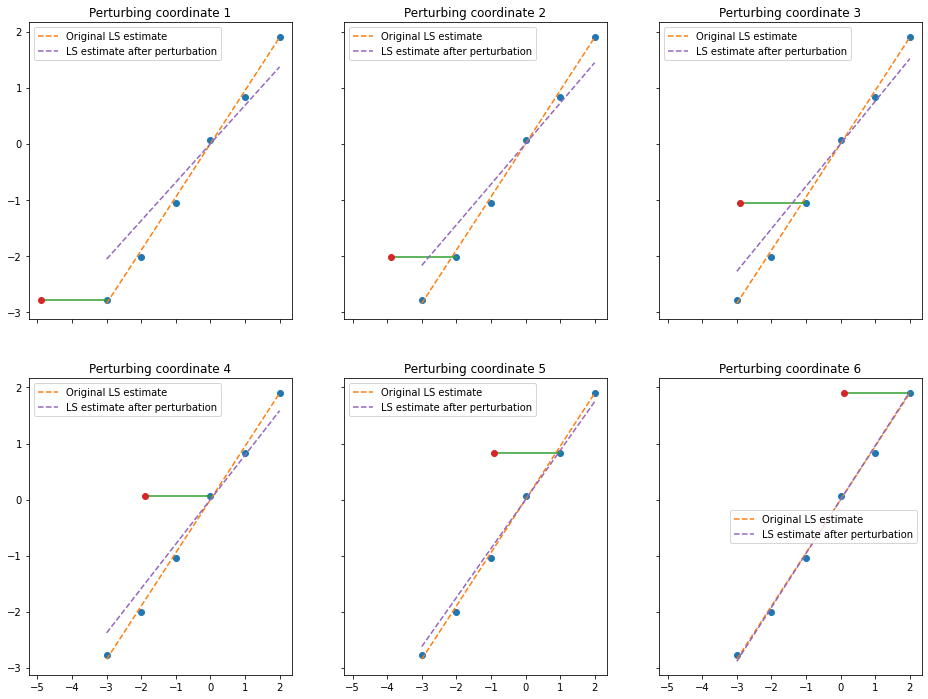

In [ ]:
n = 6
x   = np.arange(-3,3,dtype=np.float).reshape( (n,1)) # column vector
noise = rng.standard_normal( x.shape )
beta   = 1
y   = x*beta + .1*noise

betaEst,_,_,_ = np.linalg.lstsq(x,y,rcond=None)

fig, axs = plt.subplots(2, 3, sharex=True, sharey=True)
fig.set_figwidth(16)
fig.set_figheight(12)

delta = -1.9

for (i,ax) in enumerate(axs.flat):
  ax.plot( x, y, 'o')
  ax.plot( x, x*betaEst, '--', label='Original LS estimate')

  xx = x.copy()
  xx[i] += delta  # perturb
  ax.plot( [x[i],xx[i]], y[i]*[1,1] )
  ax.plot( xx[i], y[i], 'o' )

  beta2,_,_,_ = np.linalg.lstsq(xx,y,rcond=None)

  ax.plot( x, x*beta2, '--', label='LS estimate after perturbation')
  ax.set_title(f'Perturbing coordinate {i+1}')
  ax.legend()

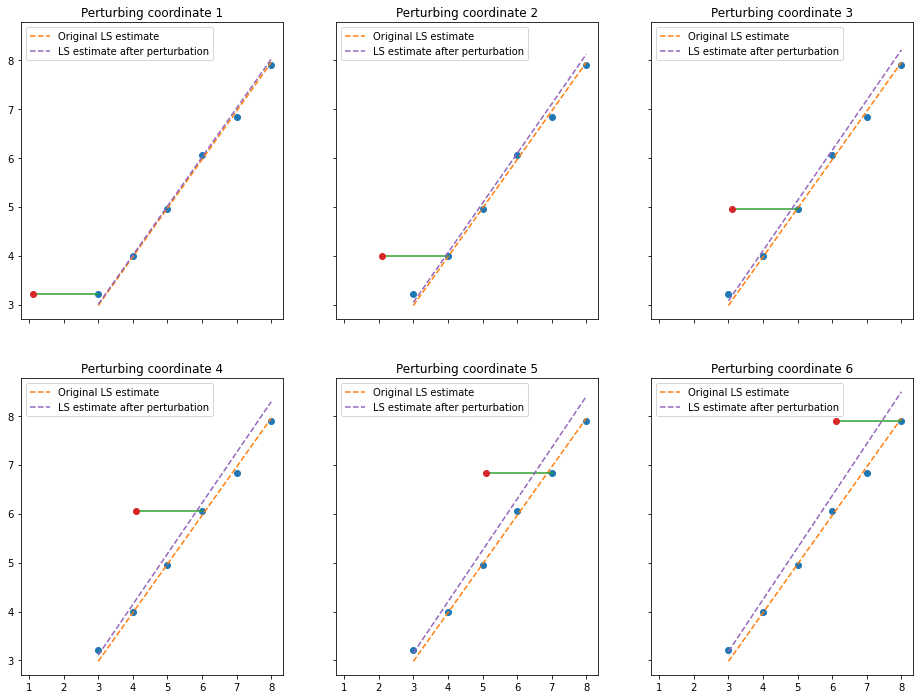

In [ ]:
x  += 6  # do you think this would change the results?


y   = x*beta + .1*noise

betaEst,_,_,_ = np.linalg.lstsq(x,y,rcond=None)

fig, axs = plt.subplots(2, 3, sharex=True, sharey=True)
fig.set_figwidth(16)
fig.set_figheight(12)

delta = -1.9

for (i,ax) in enumerate(axs.flat):
  ax.plot( x, y, 'o')
  ax.plot( x, x*betaEst, '--', label='Original LS estimate')

  xx = x.copy()
  xx[i] += delta  # perturb
  ax.plot( [x[i],xx[i]], y[i]*[1,1] )
  ax.plot( xx[i], y[i], 'o' )

  beta2,_,_,_ = np.linalg.lstsq(xx,y,rcond=None)

  ax.plot( x, x*beta2, '--', label='LS estimate after perturbation')
  ax.set_title(f'Perturbing coordinate {i+1}')
  ax.legend()

## Part 2: weighted sampling

We'll show how to do simple sampling but from a weighted distribution

The hard work is done for us by `rng.choice`.  We give it the weighted distribution, and tell it to do samping **with replacement** (as weighted sampling *without replacement* is tricky and not always even possible!)

Then we need to scale it appropriately so that we have
$$ \mathbb{E}[ S^T S ] = I $$
which we will then try to verify numerically by seeing if
$$
\lim_{N \to \infty} \left\| \frac{1}{N}\sum_{i=1}^N S_{(i)}^T S_{(i)} 0 I \right\| = 0
$$
where $ S_{(i)} $ is a fresh sample of the sketch matrix.

In [28]:
import numpy as np
import numpy.linalg
from numpy.linalg import norm
from numpy.random import default_rng
rng = default_rng()
from matplotlib import pyplot as plt

In [50]:
M   = 10
m   = 5
# the sketch S will be m x M

weights   = rng.uniform(size=M) + 1e-2  # keep these away from 0
weights   = weights/sum(weights)        # normalize them so they are a discrete probability distribution

nReps     = int(1e4)
StS       = np.zeros( (M,M) )
I         = np.eye( M )

errList   = []

for trial in range(nReps):

  omega   = rng.choice( M, m, replace=True, p=weights, shuffle=False)
  scaling = 1/np.sqrt( m*weights[omega] )
  S       = scaling.reshape( (m,1 )) * I[omega,:]

  StS    += S.T@S

  errList.append( norm( StS/(trial+1) - I ) )

In [15]:
with np.printoptions(precision=2):
  print(weights)

[0.08 0.01 0.03 0.21 0.15 0.12 0.08 0.02 0.07 0.24]


In [49]:
# A typical draw of the S matrix:
with np.printoptions(precision=2):
  print(S)

[[0.   0.   0.   0.   1.15 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.53 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.99 0.   0.  ]
 [0.   0.   0.   2.81 0.   0.   0.   0.   0.   0.  ]
 [0.97 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]]


#### Check if its converging
If we have the scaling off, then we should detect that here

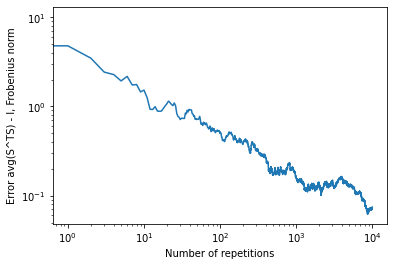

In [52]:
plt.loglog( errList)
plt.xlabel('Number of repetitions')
plt.ylabel('Error avg(S^TS) - I, Frobenius norm')
plt.show()

In [34]:
with np.printoptions(precision=2):
  print(StS/nReps)

[[1.01 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.07 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   1.13 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   1.03 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.97 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.95 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   1.03 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.9  0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   1.06]]


### If you wanted to get weights from leverage scores, here's how

In [47]:
N = 3
A = rng.standard_normal( (M,N) )  # whatever matrix we want, as long as M > N

Q,_ = np.linalg.qr( A )
print( Q.shape )

levScores = np.sum(Q**2,axis=1)/N  # the /N normalizes them to a probability

(10, 3)


In [48]:
with np.printoptions(precision=2):
  print(levScores)

[0.12 0.01 0.13 0.12 0.08 0.05 0.22 0.01 0.07 0.18]
